# **Geospatial Integration of Innovative Businesses**

## **Import Libraries**

In [ ]:
#Import Libraries

from IPython.display import clear_output
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats

try:
  import geopandas as gpd
except:
  !pip install geopandas
finally:
  import geopandas as gpd

clear_output(wait=True)
print("All packages imported successfully!")

All packages imported successfully!


## **Get Belgium Geodata & Filter Flanders Region**

In [ ]:
#Get Belgium Shapefile from Bpost

!wget 'https://bgu.bpost.be/assets/9738c7c0-5255-11ea-8895-34e12d0f0423_x-shapefile_31370.zip' -O postal.zip
!unzip postal.zip
clear_output(wait=True)
print("Shapefile imported successfully!")

Shapefile imported successfully!


In [ ]:
#Create a Geodataframe from the Bpost Shapefile & Filter the Zipcodes of Flanders
postal_gpd = gpd.read_file('/content/31370/postaldistricts.shp')

for i in range(len(postal_gpd)):
  temp = int(postal_gpd["nouveau_PO"][i])
  if ((temp < 1500) or (temp > 3999 and temp < 8000)):
    postal_gpd = postal_gpd.drop(index=i)

postal_gpd = postal_gpd[['nouveau_PO', 'geometry']]
postal_gpd

nouveau_PO                                           geometry
102        3500  POLYGON Z ((221718.241 185669.844 0.000, 22181...
103        3501  POLYGON Z ((219286.962 175426.290 0.000, 21932...
104        3510  POLYGON Z ((211586.538 185112.358 0.000, 21186...
105        3511  POLYGON Z ((216232.288 185926.737 0.000, 21626...
106        3512  POLYGON Z ((213395.328 180239.199 0.000, 21340...
...         ...                                                ...
1263       2150  POLYGON Z ((158007.126 210363.091 0.000, 15802...
1264       2387  POLYGON Z ((185998.012 234081.838 0.000, 18604...
1265       2387  POLYGON Z ((190042.998 238364.514 0.000, 19005...
1266       2140  POLYGON Z ((155313.624 212991.730 0.000, 15535...
1267       2940  POLYGON Z ((151807.865 227343.522 0.000, 15182...

[567 rows x 2 columns]

## **Parse the Results from Machine Learning**

Note that the CSV files are manually uploaded each run-time and destroyed afterwards!

1. Training with all data -> geospatial.csv
2. Train-test split (80%-20%), Test data only -> geospatial_test.csv

   nouveau_PO  ...                                           geometry
0        3500  ...  POLYGON Z ((221718.241 185669.844 0.000, 22181...
1        3501  ...  POLYGON Z ((219286.962 175426.290 0.000, 21932...
2        3510  ...  POLYGON Z ((211586.538 185112.358 0.000, 21186...
3        3511  ...  POLYGON Z ((216232.288 185926.737 0.000, 21626...
4        3512  ...  POLYGON Z ((213395.328 180239.199 0.000, 21340...

[5 rows x 7 columns]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8823f01250>,
      dtype=object)

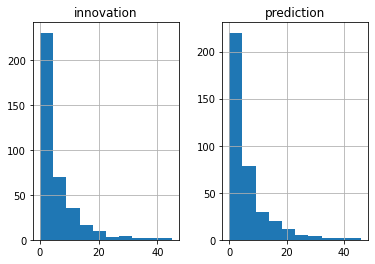

In [ ]:
#Training with All Data

geospatial_df = pd.read_csv('/content/geospatial.csv')
sum_df = geospatial_df.groupby(['activity_zip']).sum().reset_index()
count_df = geospatial_df.groupby(['activity_zip']).count().reset_index()
count_df = count_df[['activity_zip', 'innovation']]
count_df = count_df.rename(columns={'innovation':'count'})
sum_count_df = sum_df.merge(count_df, how='left', left_on="activity_zip", right_on="activity_zip")
postal_gpd["nouveau_PO"] = pd.to_numeric(postal_gpd["nouveau_PO"])
merged_gpd = postal_gpd.merge(sum_count_df, how='left', left_on="nouveau_PO", right_on="activity_zip")
merged_gpd["innovation_percent"] = merged_gpd["innovation"] / merged_gpd["count"]
merged_gpd["prediction_percent"] = merged_gpd["prediction"] / merged_gpd["count"]
merged_gpd = merged_gpd[["nouveau_PO", "innovation", "prediction", "innovation_percent", "prediction_percent", "count", "geometry"]]
merged_gpd = merged_gpd.fillna(0)
print(merged_gpd.head())
sum_df[['innovation', 'prediction']].hist()

   nouveau_PO  ...                                           geometry
0        3500  ...  POLYGON Z ((221718.241 185669.844 0.000, 22181...
1        3501  ...  POLYGON Z ((219286.962 175426.290 0.000, 21932...
2        3510  ...  POLYGON Z ((211586.538 185112.358 0.000, 21186...
3        3511  ...  POLYGON Z ((216232.288 185926.737 0.000, 21626...
4        3512  ...  POLYGON Z ((213395.328 180239.199 0.000, 21340...

[5 rows x 7 columns]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8823f208d0>,
      dtype=object)

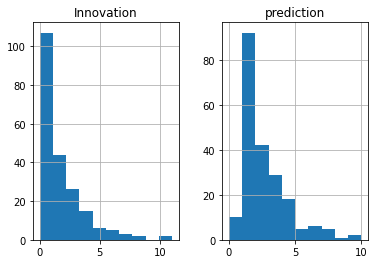

In [ ]:
#Test data after 80%-20% split

geospatial_test_df = pd.read_csv('/content/geospatial_test.csv')
sum_test_df = geospatial_test_df.groupby(['activity_zip']).sum().reset_index()
count_test_df = geospatial_test_df.groupby(['activity_zip']).count().reset_index()
count_test_df = count_test_df[['activity_zip', 'Innovation']]
count_test_df = count_test_df.rename(columns={'Innovation':'count'})
sum_count_test_df = sum_test_df.merge(count_test_df, how='left', left_on="activity_zip", right_on="activity_zip")
postal_gpd["nouveau_PO"] = pd.to_numeric(postal_gpd["nouveau_PO"])
merged_test_gpd = postal_gpd.merge(sum_count_test_df, how='left', left_on="nouveau_PO", right_on="activity_zip")
merged_test_gpd["innovation_percent"] = merged_test_gpd["Innovation"] / merged_test_gpd["count"]
merged_test_gpd["prediction_percent"] = merged_test_gpd["prediction"] / merged_test_gpd["count"]
merged_test_gpd = merged_test_gpd[["nouveau_PO", "Innovation", "prediction", "innovation_percent", "prediction_percent", "count", "geometry"]]
merged_test_gpd = merged_test_gpd.fillna(0)
print(merged_test_gpd.head())
sum_test_df[['Innovation', 'prediction']].hist()

## **Create New Features**

1. Since the data has limited number of companies, the municipalities with few businesses are affected when percent innovative map is drawn. To avoid this, we map the municipalities which represented by more than 10 businesses in the full dataset. Due to the low number of test dataset, we restrict this limit to 5 for the test dataset.

2. The absolute differences between prediction and CIS survey result for the municipality.

In [ ]:
#Training with All Data 

merged_gpd['innovation_percent_l10'] = np.where(merged_gpd['count'] < 10, 0, merged_gpd['innovation_percent'])
merged_gpd['prediction_percent_l10'] = np.where(merged_gpd['count'] < 10, 0, merged_gpd['prediction_percent'])
merged_gpd['abs_diff_count'] = abs(merged_gpd['prediction']-merged_gpd['innovation'])
merged_gpd['abs_diff_percent_l10'] = abs(merged_gpd['innovation_percent_l10']-merged_gpd['prediction_percent_l10'])
merged_gpd

nouveau_PO  innovation  ...  abs_diff_percent_l10  abs_diff_count
0          3500        30.0  ...              0.029412             1.0
1          3501         0.0  ...              0.000000             0.0
2          3510         2.0  ...              0.000000             0.0
3          3511         1.0  ...              0.000000             0.0
4          3512         0.0  ...              0.000000             0.0
..          ...         ...  ...                   ...             ...
562        2150         2.0  ...              0.000000             0.0
563        2387         1.0  ...              0.000000             1.0
564        2387         1.0  ...              0.000000             1.0
565        2140         5.0  ...              0.300000             3.0
566        2940         4.0  ...              0.000000             0.0

[567 rows x 11 columns]

In [ ]:
#Test data after 80%-20% split

merged_test_gpd['innovation_percent_l5'] = np.where(merged_test_gpd['count'] < 5, 0, merged_test_gpd['innovation_percent'])
merged_test_gpd['prediction_percent_l5'] = np.where(merged_test_gpd['count'] < 5, 0, merged_test_gpd['prediction_percent'])
merged_test_gpd['abs_diff_count'] = abs(merged_test_gpd['prediction']-merged_test_gpd['Innovation'])
merged_test_gpd['abs_diff_percent_l5'] = abs(merged_test_gpd['innovation_percent_l5']-merged_test_gpd['prediction_percent_l5'])
merged_test_gpd

nouveau_PO  Innovation  ...  abs_diff_count  abs_diff_percent_l5
0          3500         8.0  ...             1.0                  0.1
1          3501         0.0  ...             0.0                  0.0
2          3510         1.0  ...             0.0                  0.0
3          3511         0.0  ...             0.0                  0.0
4          3512         0.0  ...             0.0                  0.0
..          ...         ...  ...             ...                  ...
562        2150         0.0  ...             0.0                  0.0
563        2387         0.0  ...             0.0                  0.0
564        2387         0.0  ...             0.0                  0.0
565        2140         0.0  ...             0.0                  0.0
566        2940         2.0  ...             0.0                  0.0

[567 rows x 11 columns]

## **Create Choropleth Maps**

### **Full Data**

#### **Original Maps**

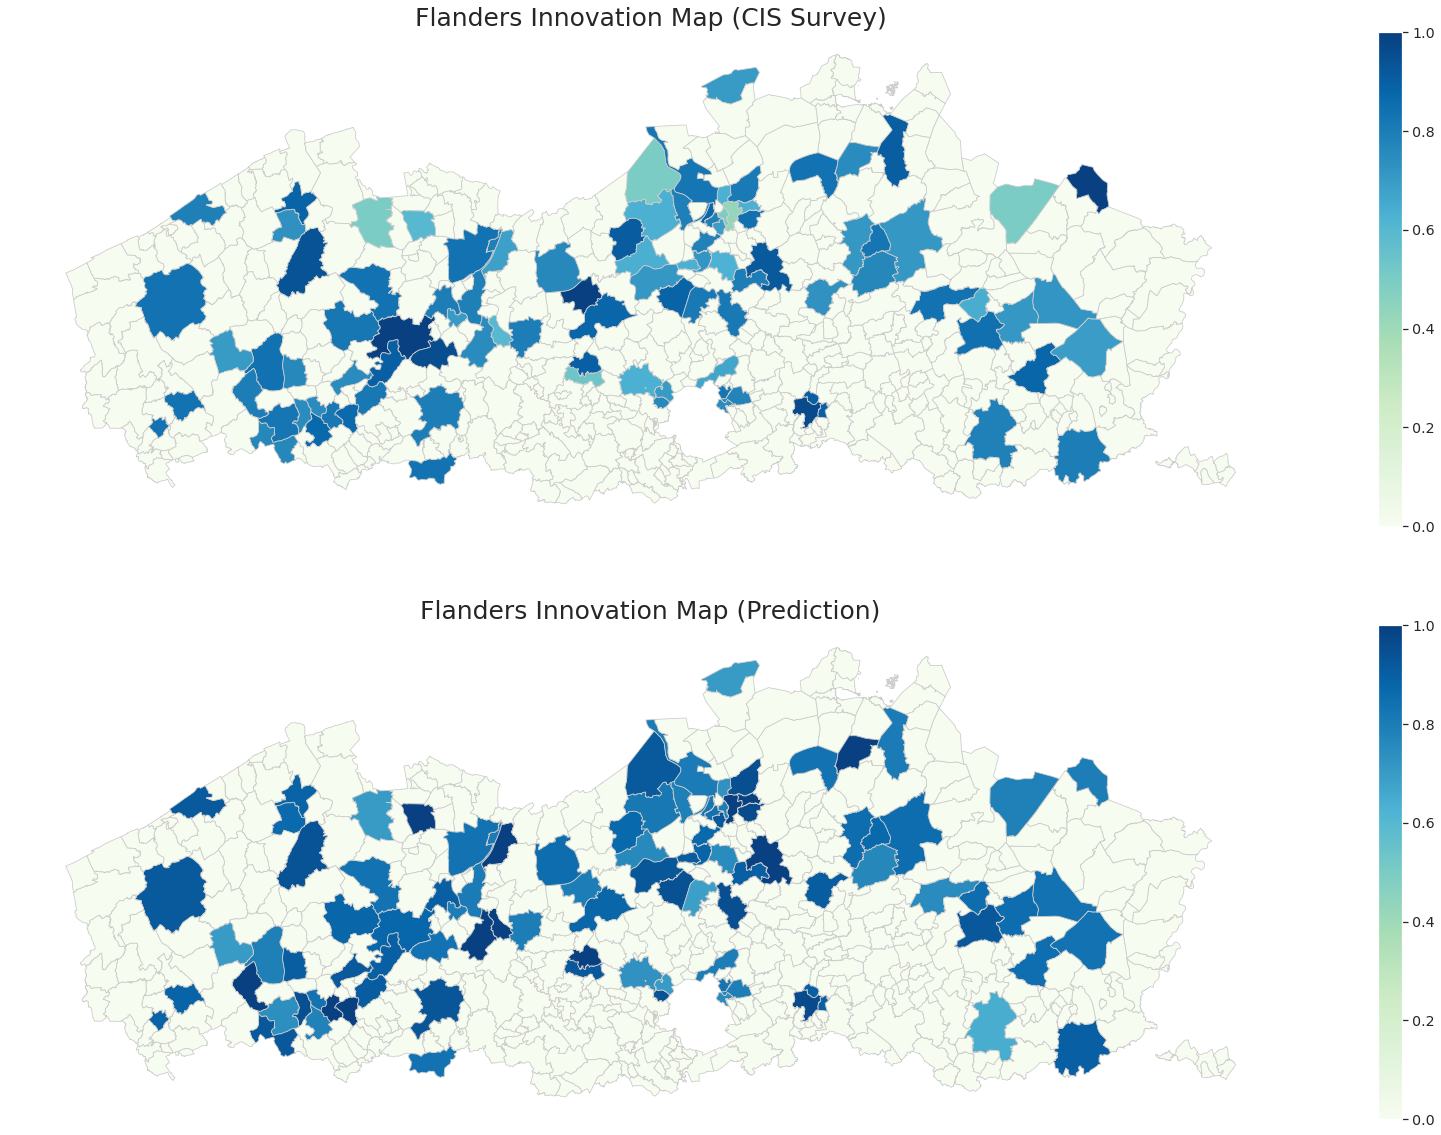

In [ ]:
#Percentage Innovativeness - > Municipalities with > 10 Businesses

real_sum = 'innovation_percent_l10'
predicted_sum = 'prediction_percent_l10'
vmin, vmax = 0, 1

fig, ax = plt.subplots(2, figsize=(30, 20))
sm = plt.cm.ScalarMappable(cmap='GnBu', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([]) 
fig.colorbar(sm, ax=ax[0])
fig.colorbar(sm, ax=ax[1])

ax[0].axis('off')
ax[1].axis('off')

ax[0].set_title('Flanders Innovation Map (CIS Survey)', fontdict={'fontsize': '25', 'fontweight' : '3'})
ax[1].set_title('Flanders Innovation Map (Prediction)', fontdict={'fontsize': '25', 'fontweight' : '3'})

merged_gpd.plot(column=real_sum, cmap='GnBu', linewidth=0.8, ax=ax[0], edgecolor='0.8')
merged_gpd.plot(column=predicted_sum, cmap='GnBu', linewidth=0.8, ax=ax[1], edgecolor='0.8')

plt.savefig('percent_geo.png', dpi=300)

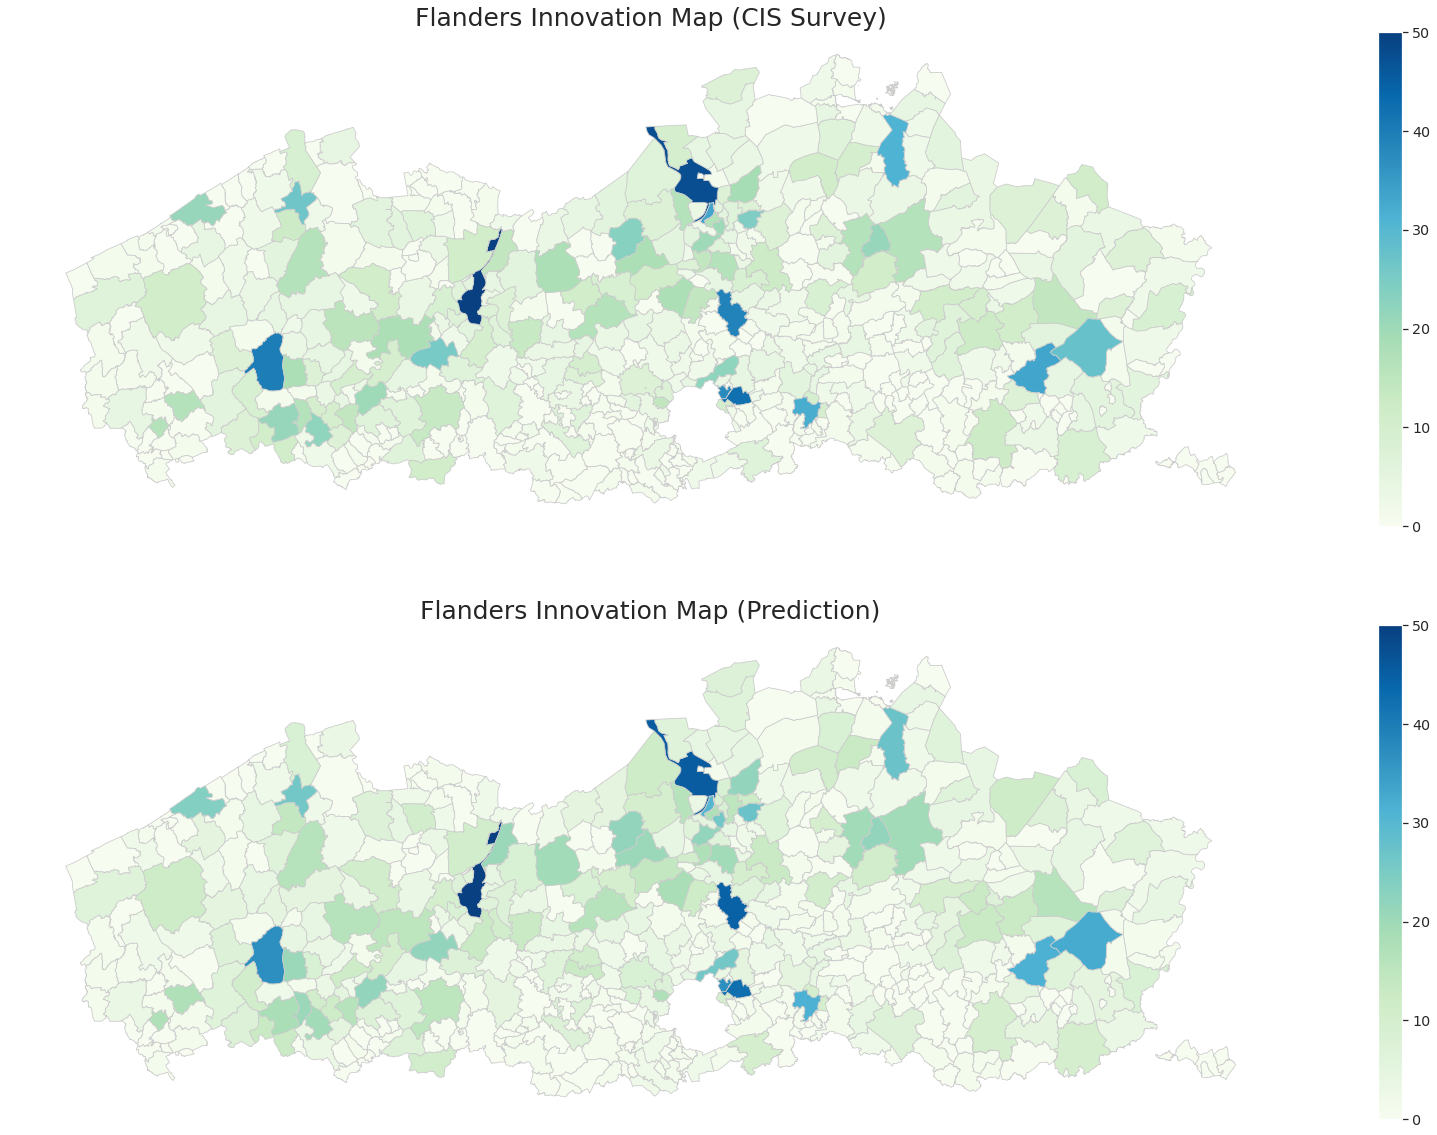

In [ ]:
#Count of Innovativeness - > All municipalities are represented

real_sum = 'innovation'
predicted_sum = 'prediction'
vmin, vmax = 0, 50
fig, ax = plt.subplots(2, figsize=(30, 20))

sm = plt.cm.ScalarMappable(cmap='GnBu', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([]) 
fig.colorbar(sm, ax=ax[0])
fig.colorbar(sm, ax=ax[1])

ax[0].axis('off')
ax[1].axis('off')

ax[0].set_title('Flanders Innovation Map (CIS Survey)', fontdict={'fontsize': '25', 'fontweight' : '3'})
ax[1].set_title('Flanders Innovation Map (Prediction)', fontdict={'fontsize': '25', 'fontweight' : '3'})

merged_gpd.plot(column=real_sum, cmap='GnBu', linewidth=0.8, ax=ax[0], edgecolor='0.8')
merged_gpd.plot(column=predicted_sum, cmap='GnBu', linewidth=0.8, ax=ax[1], edgecolor='0.8')

plt.savefig('sum_geo.png', dpi=300)

#### **Difference Maps**

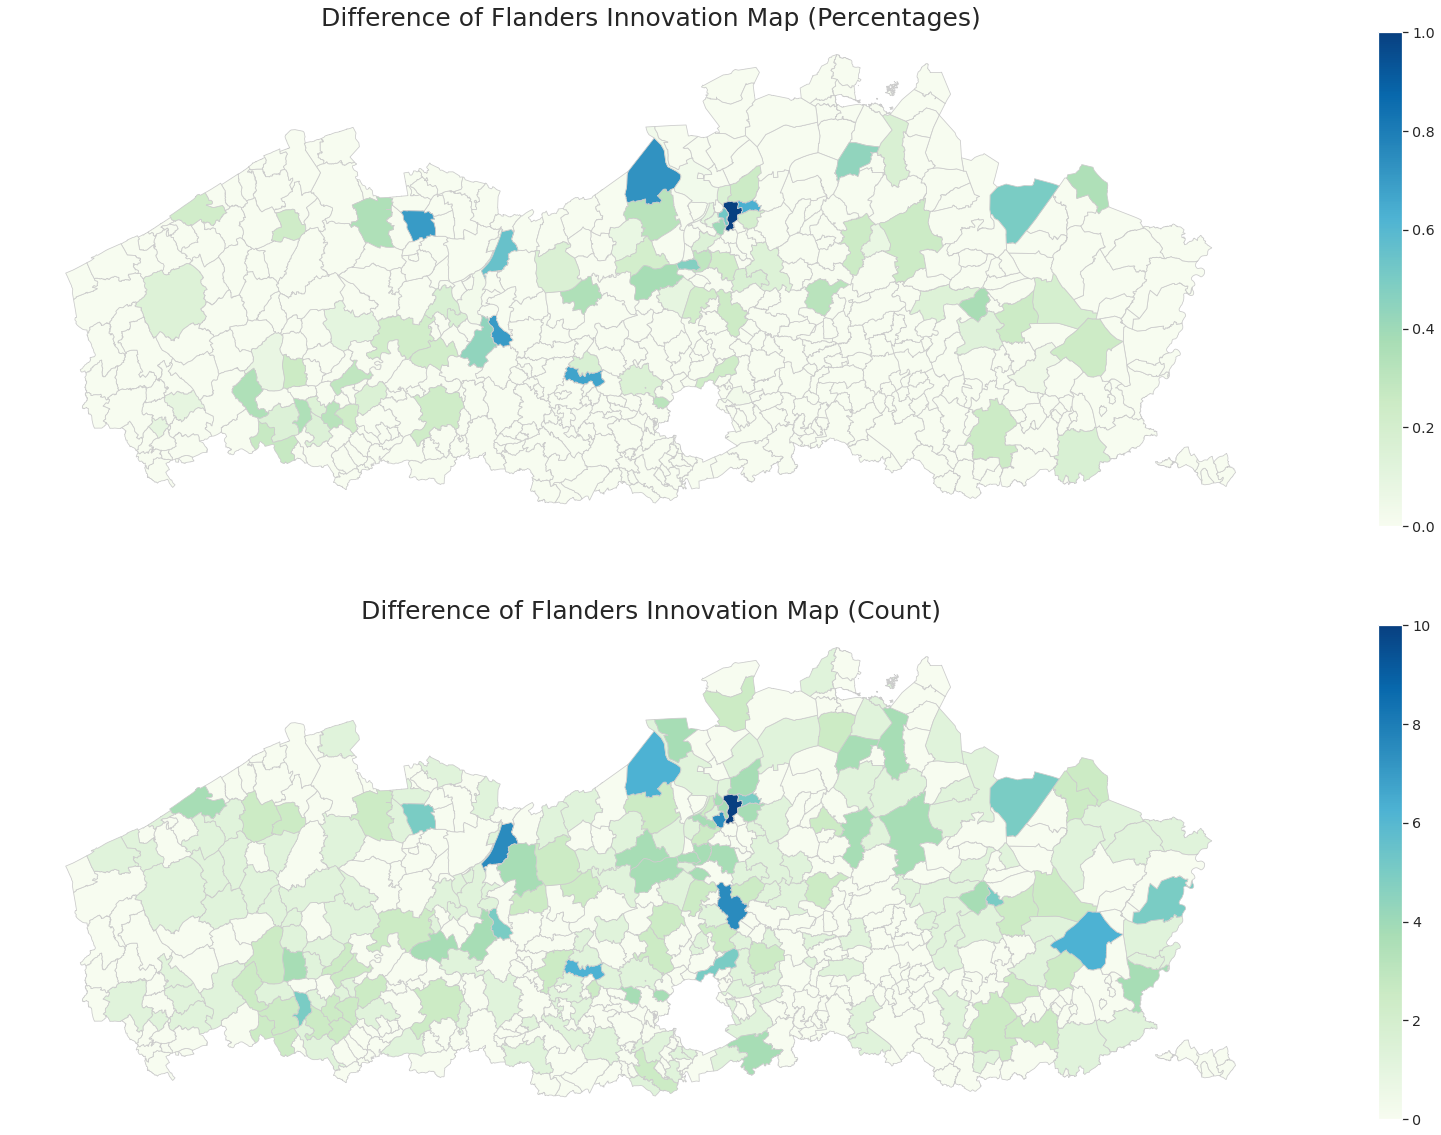

In [ ]:
#Difference Maps -> Percent (1) and Count (2)

fig, ax = plt.subplots(2, figsize=(30, 20))

sm_percent = plt.cm.ScalarMappable(cmap='GnBu', norm=plt.Normalize(vmin=0, vmax=1))
sm_count = plt.cm.ScalarMappable(cmap='GnBu', norm=plt.Normalize(vmin=0, vmax=10))
sm_percent.set_array([]) 
sm_count.set_array([]) 
fig.colorbar(sm_percent, ax=ax[0])
fig.colorbar(sm_count, ax=ax[1])

ax[0].axis('off')
ax[1].axis('off')
ax[0].set_title('Difference of Flanders Innovation Map (Percentages)', fontdict={'fontsize': '25', 'fontweight' : '3'})
ax[1].set_title('Difference of Flanders Innovation Map (Count)', fontdict={'fontsize': '25', 'fontweight' : '3'})

merged_gpd.plot(column='abs_diff_percent_l10', cmap='GnBu', linewidth=0.8, ax=ax[0], edgecolor='0.8')
merged_gpd.plot(column='abs_diff_count', cmap='GnBu', linewidth=0.8, ax=ax[1], edgecolor='0.8')

plt.savefig('dif_geo.png', dpi=300)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


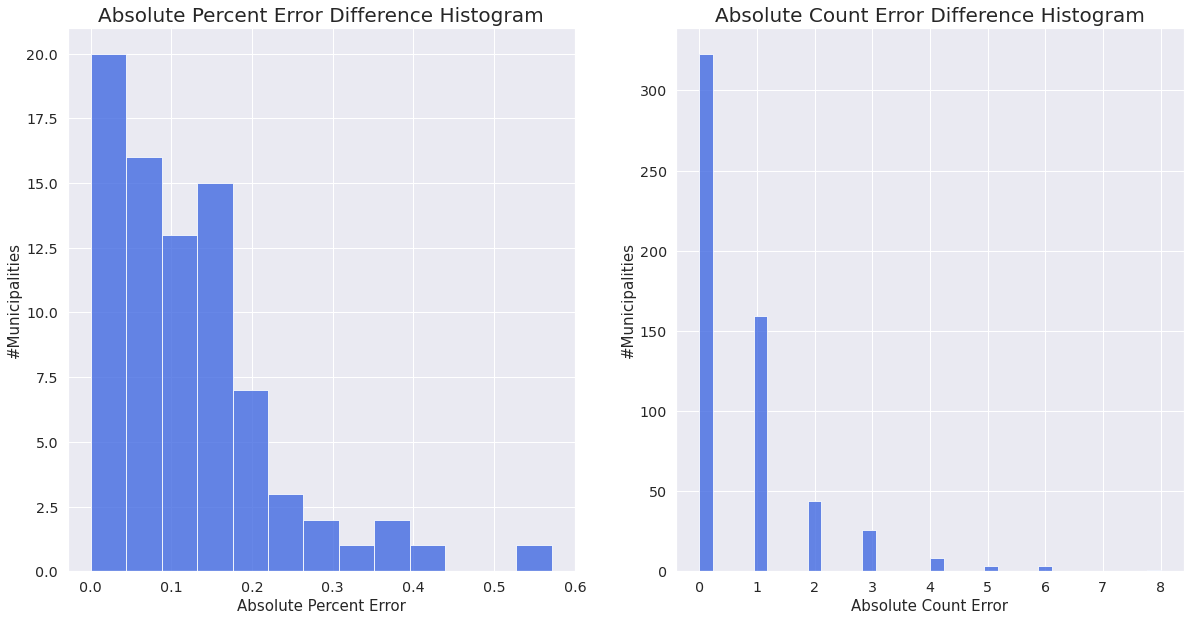

In [ ]:
#Histogram of Percentage Errors (Absolute Difference)

sns.set_style('darkgrid')
sns.set(font_scale = 1.3)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
sns.distplot(merged_gpd[merged_gpd['count'] > 10]['abs_diff_percent_l10'], kde=False, hist_kws=dict(alpha=0.8, color='#4169E1'), ax=ax[0])
ax[0].set_title('Absolute Percent Error Difference Histogram' , fontsize=20)
ax[0].set_xlabel('Absolute Percent Error', fontsize=15)
ax[0].set_ylabel('#Municipalities', fontsize=15)

sns.distplot(merged_gpd['abs_diff_count'], kde=False, hist_kws=dict(alpha=0.8, color='#4169E1'), ax=ax[1])
ax[1].set_title('Absolute Count Error Difference Histogram' , fontsize=20)
ax[1].set_xlabel('Absolute Count Error', fontsize=15)
ax[1].set_ylabel('#Municipalities', fontsize=15)

plt.savefig('full_hist.png', dpi=300)

### **Test Data**

#### **Original Maps**

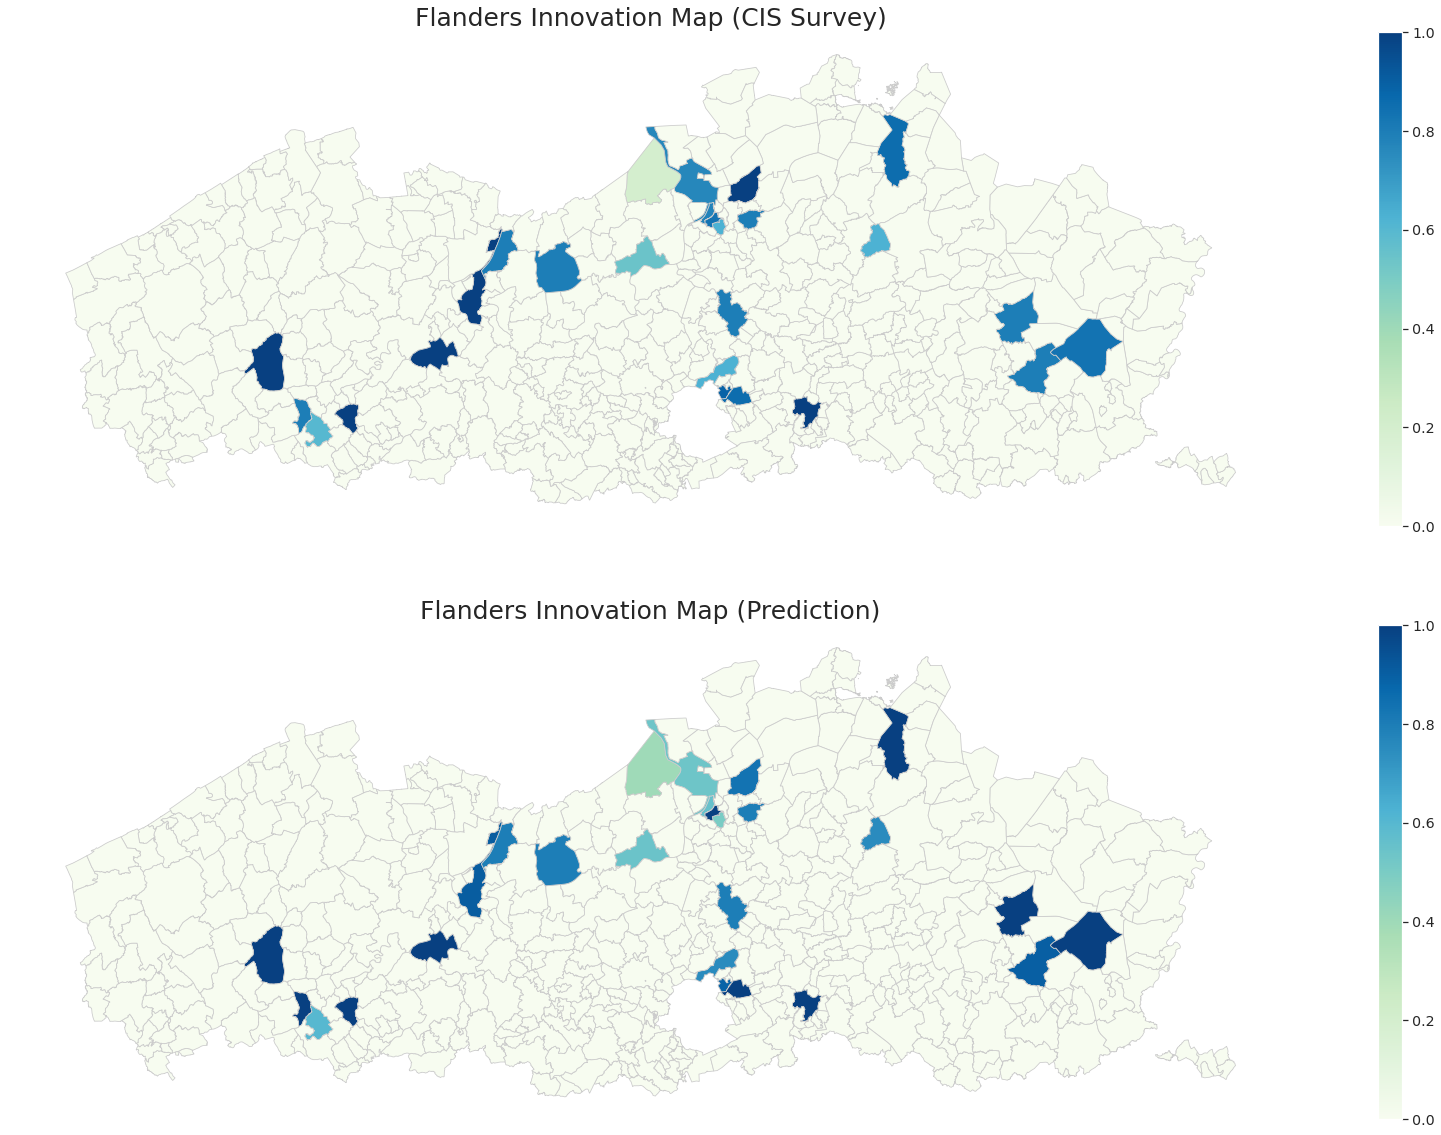

In [ ]:
#Percentage Innovativeness - > Municipalities with > 5 Businesses

real_sum = 'innovation_percent_l5'
predicted_sum = 'prediction_percent_l5'
vmin, vmax = 0, 1

fig, ax = plt.subplots(2, figsize=(30, 20))
sm = plt.cm.ScalarMappable(cmap='GnBu', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([]) 
fig.colorbar(sm, ax=ax[0])
fig.colorbar(sm, ax=ax[1])

ax[0].axis('off')
ax[1].axis('off')

ax[0].set_title('Flanders Innovation Map (CIS Survey)', fontdict={'fontsize': '25', 'fontweight' : '3'})
ax[1].set_title('Flanders Innovation Map (Prediction)', fontdict={'fontsize': '25', 'fontweight' : '3'})

merged_test_gpd.plot(column=real_sum, cmap='GnBu', linewidth=0.8, ax=ax[0], edgecolor='0.8')
merged_test_gpd.plot(column=predicted_sum, cmap='GnBu', linewidth=0.8, ax=ax[1], edgecolor='0.8')

plt.savefig('percent_test_geo.png', dpi=300)

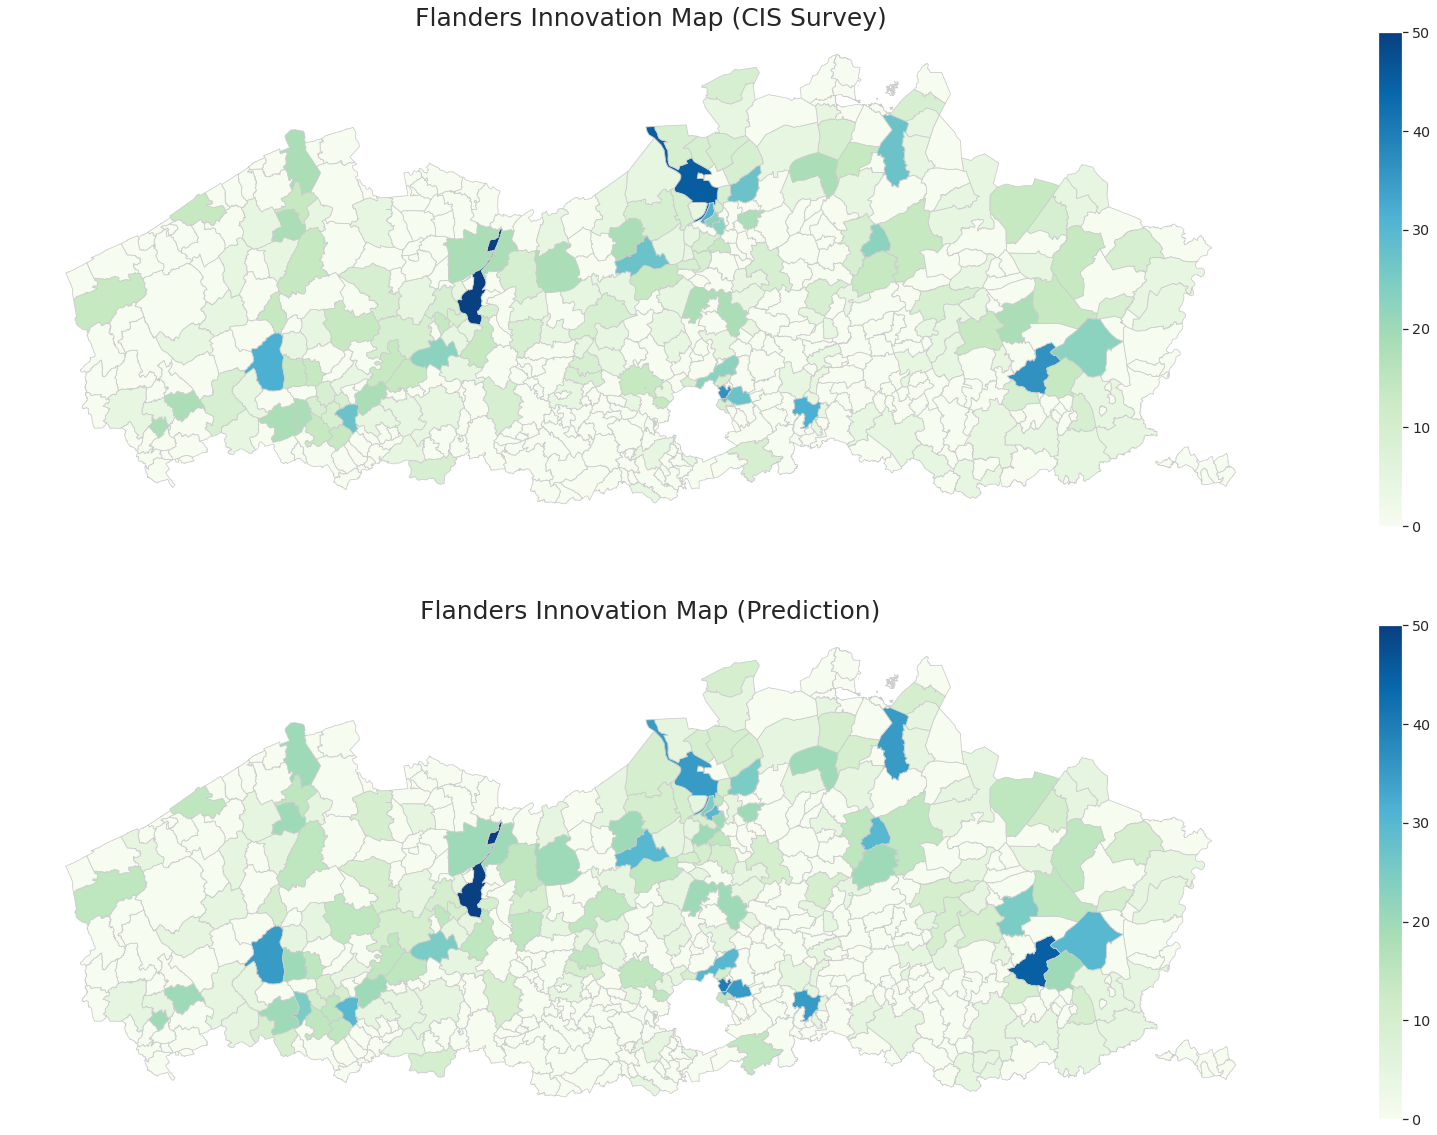

In [ ]:
#Count of Innovativeness - > All municipalities are represented

real_sum = 'Innovation'
predicted_sum = 'prediction'
vmin, vmax = 0, 50
fig, ax = plt.subplots(2, figsize=(30, 20))

sm = plt.cm.ScalarMappable(cmap='GnBu', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([]) 
fig.colorbar(sm, ax=ax[0])
fig.colorbar(sm, ax=ax[1])

ax[0].axis('off')
ax[1].axis('off')

ax[0].set_title('Flanders Innovation Map (CIS Survey)', fontdict={'fontsize': '25', 'fontweight' : '3'})
ax[1].set_title('Flanders Innovation Map (Prediction)', fontdict={'fontsize': '25', 'fontweight' : '3'})

merged_test_gpd.plot(column=real_sum, cmap='GnBu', linewidth=0.8, ax=ax[0], edgecolor='0.8')
merged_test_gpd.plot(column=predicted_sum, cmap='GnBu', linewidth=0.8, ax=ax[1], edgecolor='0.8')

plt.savefig('sum_test_geo.png', dpi=300)

#### **Difference Maps**

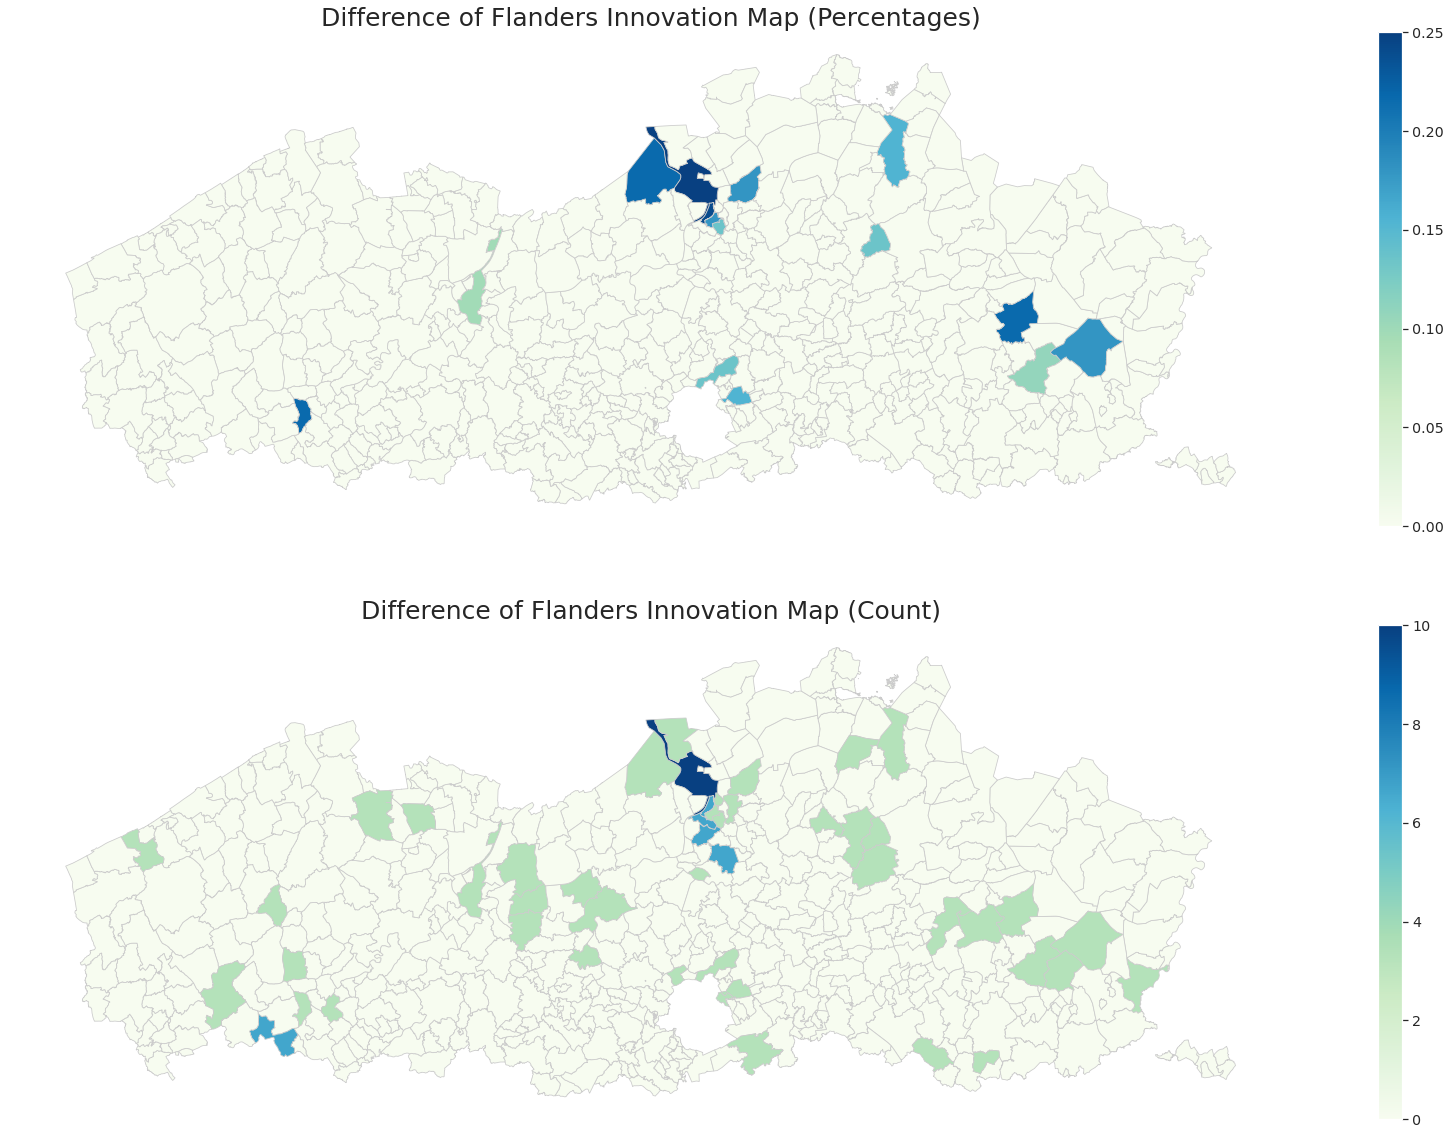

In [ ]:
#Difference Maps -> Percent (1) and Count (2)

fig, ax = plt.subplots(2, figsize=(30, 20))

sm_percent = plt.cm.ScalarMappable(cmap='GnBu', norm=plt.Normalize(vmin=0, vmax=0.25))
sm_count = plt.cm.ScalarMappable(cmap='GnBu', norm=plt.Normalize(vmin=0, vmax=10))
sm_percent.set_array([]) 
sm_count.set_array([]) 
fig.colorbar(sm_percent, ax=ax[0])
fig.colorbar(sm_count, ax=ax[1])

ax[0].axis('off')
ax[1].axis('off')
ax[0].set_title('Difference of Flanders Innovation Map (Percentages)', fontdict={'fontsize': '25', 'fontweight' : '3'})
ax[1].set_title('Difference of Flanders Innovation Map (Count)', fontdict={'fontsize': '25', 'fontweight' : '3'})

merged_test_gpd.plot(column='abs_diff_percent_l5', cmap='GnBu', linewidth=0.8, ax=ax[0], edgecolor='0.8')
merged_test_gpd.plot(column='abs_diff_count', cmap='GnBu', linewidth=0.8, ax=ax[1], edgecolor='0.8')

plt.savefig('dif_test_geo.png', dpi=300)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


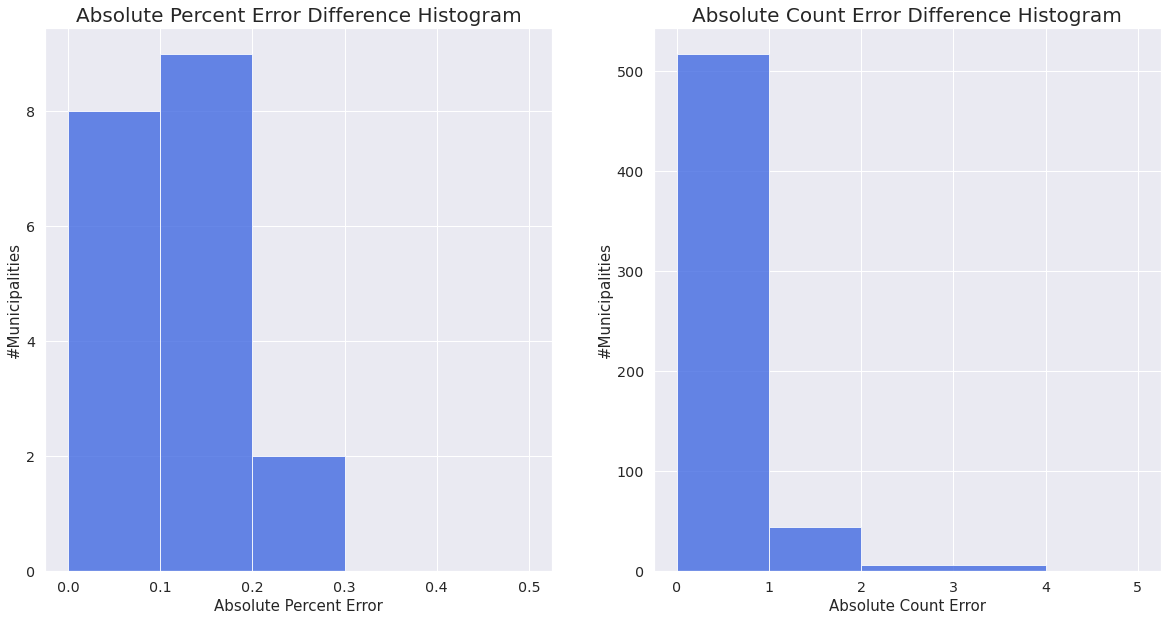

In [ ]:
#Histogram of Percentage Errors (Absolute Difference)

sns.set_style('darkgrid')
sns.set(font_scale = 1.3)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
sns.distplot(merged_test_gpd[merged_test_gpd['count'] > 5]['abs_diff_percent_l5'], kde=False, bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5], hist_kws=dict(alpha=0.8, color='#4169E1'), ax=ax[0])
ax[0].set_title('Absolute Percent Error Difference Histogram' , fontsize=20)
ax[0].set_xlabel('Absolute Percent Error', fontsize=15)
ax[0].set_ylabel('#Municipalities', fontsize=15)

sns.distplot(merged_test_gpd['abs_diff_count'], kde=False, bins = [0, 1, 2, 4, 5], hist_kws=dict(alpha=0.8, color='#4169E1'), ax=ax[1])
ax[1].set_title('Absolute Count Error Difference Histogram' , fontsize=20)
ax[1].set_xlabel('Absolute Count Error', fontsize=15)
ax[1].set_ylabel('#Municipalities', fontsize=15)

plt.savefig('test_hist.png', dpi=300)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, '#Municipalities')

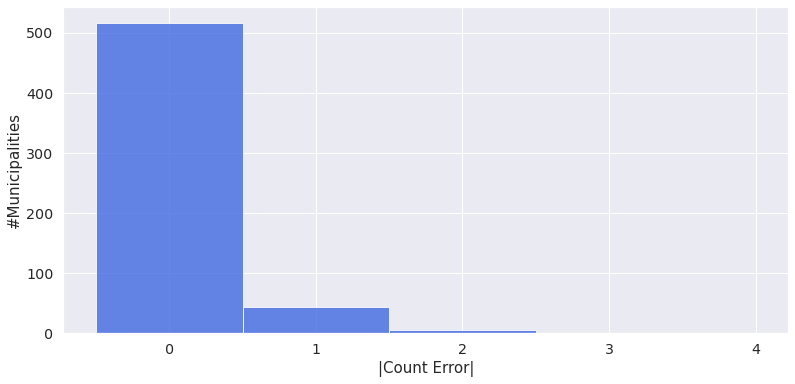

In [ ]:
sns.set_style('darkgrid')
sns.set(font_scale = 1.3)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13, 6))
sns.distplot(merged_test_gpd['abs_diff_count'], kde=False, bins = [-0.5, 0.5, 1.5, 2.5, 4], hist_kws=dict(alpha=0.8, color='#4169E1'), ax=ax)
#ax.set_title('Absolute Count Error Difference Histogram' , fontsize=20)
ax.set_xlabel('|Count Error|', fontsize=15)
ax.set_ylabel('#Municipalities', fontsize=15)

#plt.savefig('test_hist.png', dpi=300)